# Model analysis

#### Required libraries

In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

### Data preparation

In [2]:
data = pd.read_csv('../data/extension/csv/data.csv')
data.replace('?', np.NAN, inplace=True)
data[data.columns.drop(['year', 'X65'])] = data[data.columns.drop(['year', 'X65'])].astype(float)
data[['year', 'X65']] = data[['year', 'X65']].astype('category')
    

useless_col = data.isna().sum()[data.isna().sum() > 5000].index
data.drop(useless_col, axis=1, inplace=True)
useless_row = data.isna().sum(axis=1)[data.isna().sum(axis=1) > 10].index
data.drop(useless_row, axis=0, inplace=True)
data.fillna(data.mean(), inplace=True)
data = data.sample(frac=1)
data.shape, useless_col

((43184, 64), Index(['X21', 'X37'], dtype='object'))

#### Train data and test data

To get a balanced dataset that is fairly dependant on each year :

In [3]:
train_ = pd.DataFrame()
test_ = pd.DataFrame()
for year in data.year.unique():
    tr, ts = train_test_split(data[data.year == year], test_size=0.2, random_state=9)
    train_ = train_.append(tr, ignore_index=True)
    test_ = test_.append(ts, ignore_index=True)

train_.shape, test_.shape

((34545, 64), (8639, 64))

#### Data standardization

In [4]:
categ = ['year', 'X65']

scaler =  StandardScaler()
scaler.fit(train_.drop(columns=categ))

train = pd.DataFrame(scaler.transform(train_.drop(columns=categ)), 
                      columns=train_.columns.drop(categ))
test = pd.DataFrame(scaler.transform(test_.drop(columns=categ)), 
                     columns=test_.columns.drop(categ))

train = pd.concat([train, train_[categ]], axis=1)
test = pd.concat([test, test_[categ]], axis=1)

In [5]:
train_y = train.pop('X65')
train_x = train.copy()

test_y = test.pop('X65')
test_x = test.copy()

#### Save scaler used for standardize train set

In [6]:
with open('saved_model/scaler.sav', 'wb') as f:
    pickle.dump(scaler, f)

#### Encode categorical variable : year

In [7]:
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

train_x.shape, test_x.shape

((34545, 67), (8639, 67))

### Model testing

12 max features because in visualisation part, we saw that only 12 was needed to reach the biggest parts of information contained in dataset

#### Logistic regression

In [8]:
lr = LogisticRegression()
cross_val_score(lr, train_x, train_y, cv=5)

array([0.95136778, 0.6932986 , 0.35243885, 0.95020987, 0.95020987])

In [9]:
params = dict(solver=['newton-cg', 'sag'], C=[1, 2, 3])
lr = LogisticRegression(n_jobs=-1)
grid = GridSearchCV(lr, params, cv=3, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(lr)
print("\n".join([f"for {x} => mean : {y}" for x,y in zip(
                     grid.cv_results_['params'], grid.cv_results_['mean_test_score']
                 )]))
print(grid.best_estimator_)

LogisticRegression(n_jobs=-1)
for {'C': 1, 'solver': 'newton-cg'} => mean : 0.8356636271529888
for {'C': 1, 'solver': 'sag'} => mean : 0.9511940946591402
for {'C': 2, 'solver': 'newton-cg'} => mean : 0.8348820379215516
for {'C': 2, 'solver': 'sag'} => mean : 0.9511940946591402
for {'C': 3, 'solver': 'newton-cg'} => mean : 0.8347951946736142
for {'C': 3, 'solver': 'sag'} => mean : 0.9511940946591402
LogisticRegression(C=1, n_jobs=-1, solver='sag')


In [10]:
with open('saved_model/lr.sav', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

#### Linear Discriminant Analysis

In [11]:
lda = LDA(solver='svd', tol=1e-4)
cross_val_score(lda, train_x, train_y, cv=5)

array([0.95064409, 0.20147634, 0.34520191, 0.94760457, 0.94630193])

In [12]:
params = dict(solver=['svd', 'lsqr'], tol=[1e-3, 1e-4, 1e-5])
lda = LDA()
grid = GridSearchCV(lda, params, cv=5, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(lda)
print("\n".join([f"for {x} => mean : {y}" 
                 for x,y in zip(
                     grid.cv_results_['params'], 
                     grid.cv_results_['mean_test_score'])]
               ))
print(grid.best_estimator_)

LinearDiscriminantAnalysis()
for {'solver': 'svd', 'tol': 0.001} => mean : 0.6782747141409755
for {'solver': 'svd', 'tol': 0.0001} => mean : 0.678245766391663
for {'solver': 'svd', 'tol': 1e-05} => mean : 0.678245766391663
for {'solver': 'lsqr', 'tol': 0.001} => mean : 0.6785641916341005
for {'solver': 'lsqr', 'tol': 0.0001} => mean : 0.6785641916341005
for {'solver': 'lsqr', 'tol': 1e-05} => mean : 0.6785641916341005
LinearDiscriminantAnalysis(solver='lsqr', tol=0.001)


In [13]:
with open('saved_model/lda.sav', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

#### Random Forest

In [14]:
rf = RandomForestClassifier(n_jobs=-1, random_state=9)
cross_val_score(rf, train_x, train_y, cv=3)

array([0.96491533, 0.79400782, 0.9640469 ])

In [15]:
params = dict(criterion=['gini'], max_depth=[15, 45, 50, 100, 200])
rf = RandomForestClassifier(n_jobs=-1, random_state=9)

grid = GridSearchCV(rf, params, cv=3, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(rf)
print("\n".join([f"for {x} => mean : {y}" 
                 for x,y in zip(
                     grid.cv_results_['params'], 
                     grid.cv_results_['mean_test_score'])]
               ))
print(grid.best_estimator_)

RandomForestClassifier(n_jobs=-1, random_state=9)
for {'criterion': 'gini', 'max_depth': 15} => mean : 0.9401360544217687
for {'criterion': 'gini', 'max_depth': 45} => mean : 0.9076566796931539
for {'criterion': 'gini', 'max_depth': 50} => mean : 0.9076566796931539
for {'criterion': 'gini', 'max_depth': 100} => mean : 0.9076566796931539
for {'criterion': 'gini', 'max_depth': 200} => mean : 0.9076566796931539
RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=9)


In [16]:
with open('saved_model/rf.sav', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

#### Gradient Boosting

In [17]:
gbm = GradientBoostingClassifier()
cross_val_score(gbm, train_x, train_y, cv=5)

array([0.96743378, 0.84093212, 0.56752063, 0.96468375, 0.96598639])

In [18]:
params = dict(n_estimators=[100, 300], max_depth=[3,5,7])
gbm = GradientBoostingClassifier(random_state=9)

grid = GridSearchCV(gbm, params, cv=3, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(gbm)
print("\n".join([f"for {x} => mean : {y}" 
                 for x,y in zip(
                     grid.cv_results_['params'], 
                     grid.cv_results_['mean_test_score'])]
               ))
print(grid.best_estimator_)

GradientBoostingClassifier(random_state=9)
for {'max_depth': 3, 'n_estimators': 100} => mean : 0.8810826458242872
for {'max_depth': 3, 'n_estimators': 300} => mean : 0.8787668258792879
for {'max_depth': 5, 'n_estimators': 100} => mean : 0.8624113475177305
for {'max_depth': 5, 'n_estimators': 300} => mean : 0.8616297582862932
for {'max_depth': 7, 'n_estimators': 100} => mean : 0.8669561441597917
for {'max_depth': 7, 'n_estimators': 300} => mean : 0.8603850050658561
GradientBoostingClassifier(random_state=9)


In [19]:
with open('saved_model/gbm.sav', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

#### SVM

In [20]:
svm = SVC()
cross_val_score(svm, train_x, train_y, cv=5)

array([0.95151252, 0.95151252, 0.35287306, 0.95136778, 0.95136778])

In [21]:
params = dict(C=[1, 2], 
              kernel=['linear', 'rbf'])
svm = SVC(random_state=9)

grid = GridSearchCV(svm, params, cv=3, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(svm)
print("\n".join([f"for {x} => mean : {y}" 
                 for x,y in zip(
                     grid.cv_results_['params'], 
                     grid.cv_results_['mean_test_score'])]
               ))
print(grid.best_estimator_)

KeyboardInterrupt: 

In [ ]:
svm = SVC()
svm.fit(train_x, train_y)
with open('saved_model/svm.sav', 'wb') as f:
    pickle.dump(svm, f)

#### Bonus neural network : MultiLayer Perceptron

In [ ]:
mlp = MLPClassifier()
mlp.fit(train_x, train_y)
mlp.score(train_x, train_y)

0.9617021276595744

In [ ]:
params = dict(hidden_layer_sizes=[100, 120], 
              activation=['relu', 'tanh'])
mlp = MLPClassifier(random_state=9)

grid = GridSearchCV(mlp, params, cv=3, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(mlp)
print("\n".join([f"for {x} => mean : {y}" 
                 for x,y in zip(
                     grid.cv_results_['params'], 
                     grid.cv_results_['mean_test_score'])]
               ))
print(grid.best_estimator_)

In [ ]:
with open('saved_model/mlp.sav', 'wb') as f:
    pickle.dump(mlp, f)

### Underlying variables

In [ ]:
with open('../data/udata_description.json', 'r') as f:
    udesc = json.loads(f.read())
    udesc['U35'] = 'bankrupt'

In [ ]:
udata = pd.read_csv('../data/extension/csv/udata.csv')
udata.head()
udata.replace(np.inf, np.NAN, inplace=True)
useless_col = udata.isna().sum()[udata.isna().sum() > 5000].index
udata.drop(useless_col, axis=1, inplace=True)
useless_row = udata.isna().sum(axis=1)[udata.isna().sum(axis=1) > 5].index
udata.drop(useless_row, axis=0, inplace=True)
udata.fillna(udata.mean(), inplace=True)
udata.shape, [udesc[var] for var in useless_col]

((43246, 33), ['financial expenses', 'receivables', 'sales (n) / sales (n-1)'])

In [ ]:
train_ = pd.DataFrame()
test_ = pd.DataFrame()
for year in udata.year.unique():
    tr, ts = train_test_split(udata[udata.year == year], test_size=0.2, random_state=9)
    train_ = train_.append(tr, ignore_index=True)
    test_ = test_.append(ts, ignore_index=True)

categ = ['year', 'U35']

uscaler =  StandardScaler()
uscaler.fit(train_.drop(columns=categ))

train = pd.DataFrame(uscaler.transform(train_.drop(columns=categ)), 
                      columns=train_.columns.drop(categ))
test = pd.DataFrame(uscaler.transform(test_.drop(columns=categ)), 
                     columns=test_.columns.drop(categ))

#### Save scaler used for standardize train set

In [ ]:
with open('saved_model/uscaler.sav', 'wb') as f:
    pickle.dump(uscaler, f)

In [ ]:
train = pd.concat([train, train_[categ]], axis=1)
test = pd.concat([test, test_[categ]], axis=1)
train_y = train.pop('U35')
train_x = train.copy()
test_y = test.pop('U35')
test_x = test.copy()

train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

train_x.shape, train_y.shape

((34594, 36), (34594,))

### Test

#### On logistic regression

In [ ]:
params = dict(solver=['newton-cg', 'sag'], C=[1, 2, 3])
lr = LogisticRegression(n_jobs=-1)
grid = GridSearchCV(lr, params, cv=3, n_jobs=-1)
grid.fit(train_x, train_y)
grid.cv_results_
print(lr)
print("\n".join([f"for {x} => mean : {y}" for x,y in zip(
                     grid.cv_results_['params'], grid.cv_results_['mean_test_score']
                 )]))
print(grid.best_estimator_)

LogisticRegression(n_jobs=-1)
for {'C': 1, 'solver': 'newton-cg'} => mean : 0.7590855965147822
for {'C': 1, 'solver': 'sag'} => mean : 0.9512054120970402
for {'C': 2, 'solver': 'newton-cg'} => mean : 0.7472623927823733
for {'C': 2, 'solver': 'sag'} => mean : 0.9512054120970402
for {'C': 3, 'solver': 'newton-cg'} => mean : 0.7436200373925544
for {'C': 3, 'solver': 'sag'} => mean : 0.9512054120970402
LogisticRegression(C=1, n_jobs=-1, solver='sag')


In [ ]:
with open('saved_model/ulr.sav', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

it appears that there is a tiny increasing with this dataset of underlying variable, let's test it on 
our best model, the MLP 

In [ ]:
mlp = MLPClassifier()
mlp.fit(train_x, train_y)
mlp.score(train_x, train_y)

0.9693010348615367

In [ ]:
with open('saved_model/umlp.sav', 'wb') as f:
    pickle.dump(mlp, f)

In [22]:
lr = LogisticRegression()
cross_val_score(lr, test_x, test_y, cv=5)

array([0.9525463 , 0.21238426, 0.35706019, 0.95081019, 0.9536769 ])

[[8240    3]
 [ 392    4]]


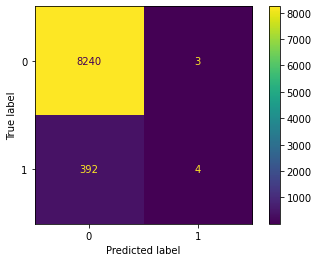

In [23]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
lr.fit(train_x,train_y)
y_pred = lr.predict(test_x)
confusion_matrix = confusion_matrix(test_y,y_pred) 
print(confusion_matrix)
plot_confusion_matrix(lr,test_x,test_y)
plt.show()

In [26]:
cr = classification_report(test_y,lr.predict(test_x))
print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8243
           1       0.57      0.01      0.02       396

    accuracy                           0.95      8639
   macro avg       0.76      0.50      0.50      8639
weighted avg       0.94      0.95      0.93      8639

